In [2]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
## Training with weather data

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import holidays
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import  randint
from scipy.stats import uniform
import math
import matplotlib.pyplot as plt

In [28]:
import warnings
warnings.filterwarnings('ignore')

## Build X_train

In [4]:
df_train = pd.read_csv('fl_wea_train.csv')

In [5]:
col = df_train.columns.tolist()

In [17]:
col = ['fl_date', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
 'crs_dep_time',  'crs_arr_time', 'arr_delay',  'distance',     
 'tmpf', 'sknt', 'vsby', 'gust', 'skyl1', 'ice_accretion_3hr',
 'tmpf_arr', 'sknt_arr', 'vsby_arr', 'gust_arr', 'skyl1_arr', 'ice_accretion_3hr_arr']

In [81]:
X_train = df_train[col]

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949679 entries, 0 to 951087
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fl_date                949679 non-null  object 
 1   arr_delay              949679 non-null  float64
 2   distance               949679 non-null  float64
 3   tmpf                   949679 non-null  float64
 4   sknt                   949679 non-null  float64
 5   vsby                   949679 non-null  float64
 6   gust                   949679 non-null  float64
 7   skyl1                  949679 non-null  float64
 8   ice_accretion_3hr      949679 non-null  float64
 9   tmpf_arr               949679 non-null  float64
 10  sknt_arr               949679 non-null  float64
 11  vsby_arr               949679 non-null  float64
 12  gust_arr               949679 non-null  float64
 13  skyl1_arr              949679 non-null  float64
 14  ice_accretion_3hr_arr  949679 non-nu

In [82]:
# after test data, arr_delay should be 0. 
X_train['arr_delay'].fillna(0,inplace=True)

#remove outliner
X_train = X_train[(X_train['arr_delay'] > -80) & (X_train['arr_delay'] <= 480)] 

#combine features
def combine_str_num(x,y):
    return x + str(y)
X_train['uni_fl'] = np.vectorize(combine_str_num)(X_train['op_unique_carrier'],X_train['op_carrier_fl_num'])
X_train.drop(columns=['op_unique_carrier','op_carrier_fl_num'],inplace=True)

# feature coding
total_target_mean = np.mean(X_train['arr_delay'])
unifl_target_mean = X_train.groupby(['uni_fl'])['arr_delay'].mean()
X_train['uni_fl'] =X_train['uni_fl'].map(unifl_target_mean)

In [83]:
## Combine the airportid and related hour
## Combine the airportid and related hour
def airport_hour(id,t):
    '''
    combine airport and hour to a new field
    '''
    t = t // 100
    if t == 24:
        t = 0
    l = '0' + str(t)
    return str(id) + l[-2:]
    
X_train['arr_airport_hour'] = np.vectorize(airport_hour)(X_train['dest_airport_id'],X_train['crs_arr_time'])
X_train['dep_airport_hour'] = np.vectorize(airport_hour)(X_train['origin_airport_id'],X_train['crs_dep_time'])

# feature coding
dep_hour_target_mean = X_train.groupby(['dep_airport_hour'])['arr_delay'].mean()
X_train['dep_airport_hour'] =X_train['dep_airport_hour'].map(dep_hour_target_mean)
arr_hour_target_mean = X_train.groupby(['arr_airport_hour'])['arr_delay'].mean()
X_train['arr_airport_hour'] =X_train['arr_airport_hour'].map(arr_hour_target_mean)

X_train.drop(columns=['dest_airport_id','crs_arr_time','origin_airport_id','crs_dep_time'],inplace=True)

In [84]:
pi=3.14159
def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

#transform fl_date
#def getmonth(x):
#    return x.split(sep='-')[1]
#X_train['month'] = X_train['fl_date'].apply(getmonth)

#sin_m, cos_m = transformation(X_train['month'].astype('int32'))
#X_train['mon_sin'] = sin_m
#X_train['mon_cos'] = cos_m


def getdayofweek(x):
    year_s, mon_s, day_s = x.split('-')
    fl_d = datetime(int(year_s), int(mon_s), int(day_s))
    return fl_d.weekday() + 1
X_train['day_of_week'] = X_train['fl_date'].apply(getdayofweek)

us_holidays = holidays.UnitedStates()
def isholiday(x):
    year_s, mon_s, day_s = x.split('-')
    if datetime(int(year_s), int(mon_s), int(day_s)) in us_holidays:
        return 1
    else:
        return 0
X_train['is_holiday'] = X_train['fl_date'].apply(isholiday)



sin_l, cos_l = transformation(X_train['day_of_week'])

X_train['dow_sin'] = sin_l
X_train['dow_cos'] = cos_l

In [85]:
y_train = X_train['arr_delay']

X_train = X_train.drop(columns=['fl_date','arr_delay','day_of_week'])

#X_train = pd.get_dummies(X_train,columns=['month','day_of_week'])

In [86]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
#x_small = X[:100000]
#y_small = y_train[:100000]

### Build X_test

In [23]:
df_test = pd.read_csv('fl_wea_test.csv')

In [34]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237772 entries, 0 to 237771
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fl_date                237772 non-null  object 
 1   arr_delay              237772 non-null  float64
 2   distance               237772 non-null  float64
 3   tmpf                   237772 non-null  float64
 4   sknt                   237772 non-null  float64
 5   vsby                   237772 non-null  float64
 6   gust                   237772 non-null  float64
 7   skyl1                  237772 non-null  float64
 8   ice_accretion_3hr      237772 non-null  float64
 9   tmpf_arr               237772 non-null  float64
 10  sknt_arr               237772 non-null  float64
 11  vsby_arr               237772 non-null  float64
 12  gust_arr               237772 non-null  float64
 13  skyl1_arr              237772 non-null  float64
 14  ice_accretion_3hr_arr  237772 non-nu

(-80.0, 150.0)

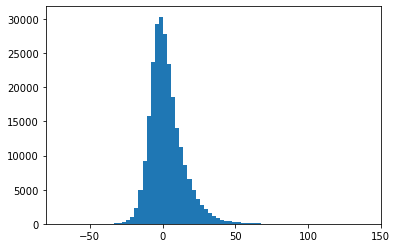

In [141]:
plt.hist(y_pred,bins=100)
#plt.hist(X_train['arr_delay'],bins=300)
plt.xlim(-80,150)

In [87]:
X_test = df_test[col]

In [88]:
# after test data, arr_delay should be 0. 
X_test['arr_delay'].fillna(0,inplace=True)

#remove outliner
#X_test = X_test[(X_test['arr_delay'] > -80) & (X_test['arr_delay'] < 480)] 

#combine features
def combine_str_num(x,y):
    return x + str(y)
X_test['uni_fl'] = np.vectorize(combine_str_num)(X_test['op_unique_carrier'],X_test['op_carrier_fl_num'])
X_test.drop(columns=['op_unique_carrier','op_carrier_fl_num'],inplace=True)

# feature coding
#unifl_target_mean = X_test.groupby(['uni_fl'])['arr_delay'].mean()
X_test['uni_fl'] =X_test['uni_fl'].map(unifl_target_mean)
X_test['uni_fl'].fillna(total_target_mean,inplace=True)

In [89]:
## Combine the airportid and related hour

    
X_test['arr_airport_hour'] = np.vectorize(airport_hour)(X_test['dest_airport_id'],X_test['crs_arr_time'])
X_test['dep_airport_hour'] = np.vectorize(airport_hour)(X_test['origin_airport_id'],X_test['crs_dep_time'])


# feature coding
#dep_hour_target_mean = X_train.groupby(['dep_airport_hour'])['arr_delay'].mean()
X_test['dep_airport_hour'] =X_test['dep_airport_hour'].map(dep_hour_target_mean)
#arr_hour_target_mean = X_train.groupby(['arr_airport_hour'])['arr_delay'].mean()
X_test['arr_airport_hour'] =X_test['arr_airport_hour'].map(arr_hour_target_mean)

X_test['arr_airport_hour'].fillna(total_target_mean,inplace=True)
X_test['dep_airport_hour'].fillna(total_target_mean,inplace=True)

X_test.drop(columns=['dest_airport_id','crs_arr_time','origin_airport_id','crs_dep_time'],inplace=True)

In [90]:

#transform fl_date
#def getmonth(x):
#    return x.split(sep='-')[1]
#X_test['month'] = X_test['fl_date'].apply(getmonth)

#sin_m, cos_m = transformation(X_test['month'].astype('int32'))
#X_test['mon_sin'] = sin_m
#X_test['mon_cos'] = cos_m

def getdayofweek(x):
    year_s, mon_s, day_s = x.split('-')
    fl_d = datetime(int(year_s), int(mon_s), int(day_s))
    return fl_d.weekday() + 1
X_test['day_of_week'] = X_test['fl_date'].apply(getdayofweek)

us_holidays = holidays.UnitedStates()
def isholiday(x):
    year_s, mon_s, day_s = x.split('-')
    if datetime(int(year_s), int(mon_s), int(day_s)) in us_holidays:
        return 1
    else:
        return 0
X_test['is_holiday'] = X_test['fl_date'].apply(isholiday)



pi=3.14159
def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

sin_l, cos_l = transformation(X_test['day_of_week'])

X_test['dow_sin'] = sin_l
X_test['dow_cos'] = cos_l



In [91]:
y_test = X_test['arr_delay']
X_test = X_test.drop(columns=['fl_date','arr_delay','day_of_week'])

#X_test = pd.get_dummies(X_test,columns=['month','day_of_week'])

X_test = scaler.transform(X_test)

In [55]:
X_test.columns.tolist()

['distance',
 'tmpf',
 'sknt',
 'vsby',
 'gust',
 'skyl1',
 'ice_accretion_3hr',
 'tmpf_arr',
 'sknt_arr',
 'vsby_arr',
 'gust_arr',
 'skyl1_arr',
 'ice_accretion_3hr_arr',
 'uni_fl',
 'arr_airport_hour',
 'dep_airport_hour',
 'is_holiday',
 'dow_sin',
 'dow_cos']

In [1]:
###  Linear Modeling

In [92]:
ent1 = LinearRegression()
ent1.fit(X_train,y_train)

LinearRegression()

In [93]:
y_pred_l = ent1.predict(X_test)
r2_score(y_test,y_pred_l)

0.042411680267979035

In [94]:
ent1.coef_

array([-0.0422602 , -1.13685465,  1.09544305, -2.99722828,  0.67967236,
       -1.10129239,  0.33804186, -0.8309967 ,  1.34379013, -2.54777865,
        0.7935485 , -1.25408169,  0.36874683,  9.3278751 ,  1.71163871,
        1.69400279,  1.83434329, -0.1376997 , -0.77733827])

In [95]:
ent = ElasticNet()

In [96]:
parameters = {'alpha': [0.0001,0.001,0.01,],
              'l1_ratio'    : [0,0.2,0.5,0.8,]
                 }

In [97]:
grid = GridSearchCV(ent, parameters, scoring='r2', cv=5, n_jobs=-1)

In [98]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'l1_ratio': [0, 0.2, 0.5, 0.8]},
             scoring='r2')

In [99]:
grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.2}

In [48]:
grid.

ElasticNet(alpha=0.001, l1_ratio=0.2)

In [100]:
grid.best_score_

0.10823081244976136

In [101]:
y_pred = grid.predict(X_test)

In [102]:
r2_score(y_test, y_pred)

0.04243202576153071

In [117]:
len(y_test)

247637

In [25]:
## flights only data round1
grid.best_score_

0.08636958850864554

In [21]:
## second round with arr_delay <480
#r2_score(y_test, y_pred)

0.02144653066658464

In [27]:
## first round with arr_delay < 180
#

0.013895135285908466